# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Zihan

Last Name: Xiao

Student ID: 915532809

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [11]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from collections import Counter
db = sql.connect("sf_data.sqlite")

In [12]:
#create a table contains the number of locationid for each permit code
db.execute("CREATE TABLE new_table AS SELECT locationid, permit FROM mobile_food_schedule GROUP BY locationid")
db.execute("CREATE TABLE left AS SELECT permit, COUNT(*) AS count FROM new_table GROUP BY permit")
#grab permits that is approved
db.execute("CREATE TABLE right AS SELECT permit, Applicant FROM mobile_food_permits WHERE Status = 'APPROVED' ")
#Errors caused by re-run this cell and creating a same table in the same sql files

OperationalError: table new_table already exists

In [13]:
pd.read_sql("SELECT * FROM left", db).head()

,permit,count
0,11MFF-0040,2
1,11MFF-0070,1
2,11MFF-0175,1
3,11MFF-0177,2
4,12MFF-0083,1


In [14]:
pd.read_sql("SELECT * FROM right", db).head()

,permit,Applicant
0,16MFF-0027,F & C Catering
1,16MFF-0069,Munch A Bunch
2,16MFF-0051,Park's Catering
3,16MFF-0024,"Off the Grid Services, LLC"
4,16MFF-0036,Roadside Rotisserie Corporation / Country Grill


In [15]:
#create a table which is merged by table one with numbers of locationid and table two with applicant and these
#two table are merged by key column 'permit'.
db.execute("CREATE TABLE tb AS SELECT * FROM left INNER JOIN right ON left.permit = right.permit")
#Errors caused by re-run this cell and creating a same table in the same sql files

OperationalError: table tb already exists

In [16]:
pd.read_sql("SELECT * FROM tb ORDER BY count",db).tail()#find the permit with the largest counts

,permit,count,permit:1,Applicant
57,17MFF-0125,7,17MFF-0125,BH & MT LLC
58,16MFF-0069,10,16MFF-0069,Munch A Bunch
59,16MFF-0027,13,16MFF-0027,F & C Catering
60,16MFF-0037,17,16MFF-0037,D & T Catering
61,16MFF-0051,23,16MFF-0051,Park's Catering


From the output we can know that machine with permit 16MFF-0051 from Park's Catering has the most location.

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

1.Which parts of the city are the most and least expensive?

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd         
import osmnx as ox              
import shapely.geometry as geom 

In [18]:
sold_price = pd.read_sql('''
SELECT RegionName, Date, MedianSoldPricePerSqft_AllHomes FROM Zillow WHERE MedianSoldPricePerSqft_AllHomes != 'NaN' 
ORDER BY MedianSoldPricePerSqft_AllHomes DESC
''', db)#get the price table with zip code, Date and median sold price

In [19]:
ls

README.md                cb_2016_us_zcta510_500k/ sf_data.sqlite
SF Find Neighborhoods/   hw5.ipynb


In [20]:
#get data from 2010 till now
price = sold_price.copy()
price['Date'] = pd.to_datetime(price['Date'])
price['Date'] = [x.year for x in price['Date']]
price = price[price['Date'] > 2010]
price.head()

,RegionName,Date,MedianSoldPricePerSqft_AllHomes
1,94123,2016,1286.297641
2,94123,2016,1276.685200
3,94105,2015,1276.585300
4,94105,2015,1270.436000
5,94105,2016,1269.393512


In [21]:
#calculate the mean median price for each district
median_price = price['MedianSoldPricePerSqft_AllHomes'].groupby(price['RegionName']).mean()
median_price = pd.DataFrame(median_price)
Mprice = list(median_price.iloc[:, 0])
Rname = list(median_price.index)
median_price.head()

,MedianSoldPricePerSqft_AllHomes
RegionName,
94080,440.870467
94102,771.767609
94103,772.299804
94105,1001.785313
94107,813.582972


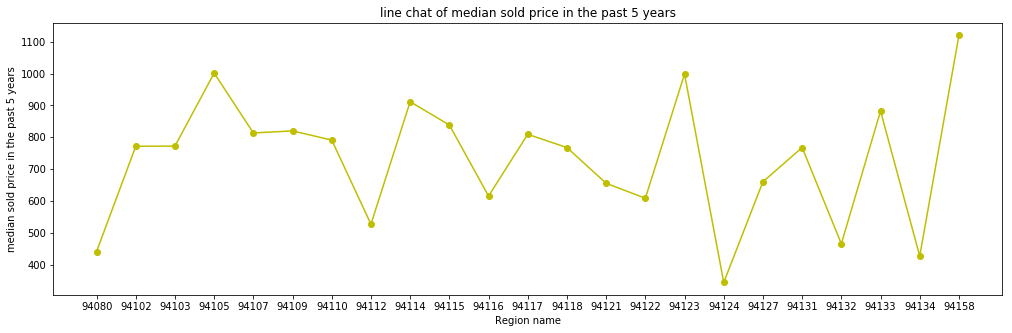

In [9]:
#Draw a line chat to show which district has highest median price
x = list(range(len(Rname)))
plt.figure(figsize=(17,5))
plt.plot(x, Mprice, marker = 'o', c = 'y')
plt.xticks(x, Rname)
plt.xlabel('Region name')
plt.ylabel('median sold price in the past 5 years')
plt.title('line chat of median sold price in the past 5 years')
plt.show()

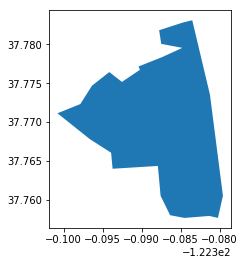

In [22]:
#draw a map of the district
zipcode = gpd.read_file("cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")
a = zipcode[zipcode['ZCTA5CE10'] == '94158']
a.plot()

In [12]:
#draw a map for San Francisco
neighborhood = gpd.read_file("SF Find Neighborhoods/geo_export_f0b7fdde-167d-4054-9c21-1629ae20e202.shp")
neighborhood.head()

,link,name,geometry
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",Seacliff,POLYGON ((-122.4934552679999 37.78351817100008...
1,None,Lake Street,POLYGON ((-122.4871507149999 37.78378542700005...
2,http://www.nps.gov/prsf/index.htm,Presidio National Park,POLYGON ((-122.4775801709999 37.81099311300005...
3,None,Presidio Terrace,POLYGON ((-122.4724105299999 37.78734653900005...
4,http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,POLYGON ((-122.4726257899999 37.78631480600006...


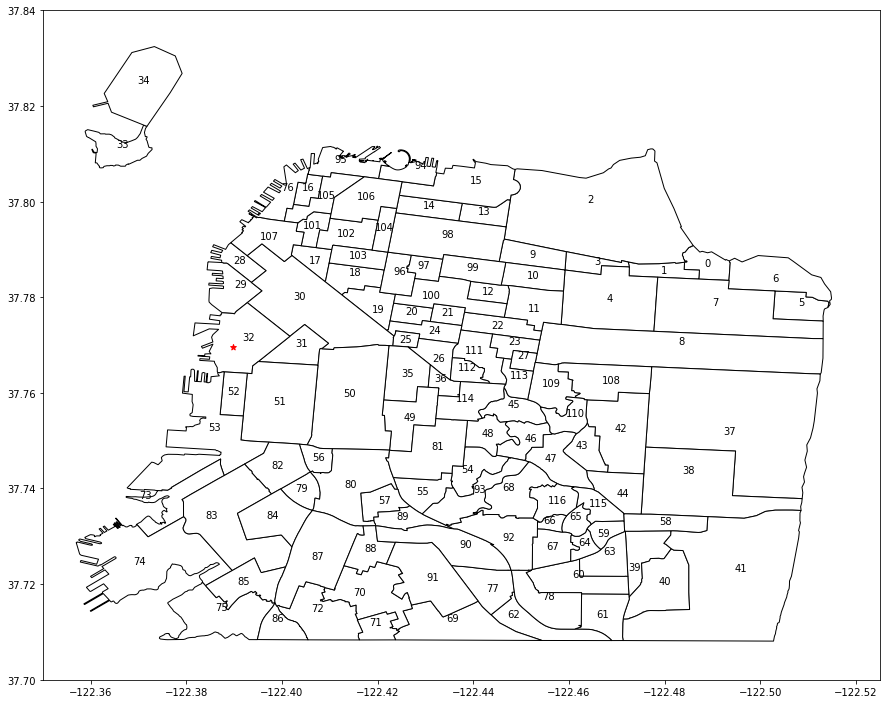

In [157]:
'''In this plot the red star mark the district with highest median price'''
ax = neighborhood.plot(edgecolor = "black", color = "white", figsize = (15,15))
ax.set_xlim([-122.35, -122.525])
ax.set_ylim([37.7, 37.84])
a.geometry.representative_point().plot(ax = ax, color = 'red', marker = '*')
# Given a row, this function gets a point and plots the county name at that point.
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.name, xy = coords, horizontalalignment = "center")
    
# Call add_label() on each row.
neighborhood.apply(add_label, axis = 1)
plt.show()

In [14]:
neighborhood.iloc[32,:]#find the name of the district we need

link                                                     None
name                                              Mission Bay
geometry    POLYGON ((-122.3937297949999 37.76402134200004...
Name: 32, dtype: object

In this part we focus on the median price of solding house. Take currency devaluation into consideration, we give up those old data that generated long time ago. Since if we take those old data into account, the mean value of median sold price may be negatively affacted and may decrease the correct rate. After using latitude and longitude data, a map of San Francisco has been drawn and the red star represent the place with the highest sold price in San Francisco. Then we find that Misson Bay has the highest median sold price. It is easy to understand why mission bay has such high house price with this map. We can find that Misson Bay is a seaside place with beautiful sea scenery and it is obvious that Mission Bay is a good place to travel and take vacations. With the development of tourism, the price in this area will rapidly increase including the house price. More merchants want to buy house here and change the house into inn to serve to tourists. Then the price of house can easily become the most expensive one.

2.Which parts of the city are the most dangerous (and at what times)?

In [16]:
crime = pd.read_sql("SELECT DayOfWeek,Datetime, PdDistrict, Lon, Lat FROM crime",db)
crime.head()#grab crime data with date, time and goegraphic coordinates

,DayOfWeek,Datetime,PdDistrict,Lon,Lat
0,Monday,2015-01-19 14:00:00,MISSION,-122.421582,37.761701
1,Sunday,2015-02-01 15:45:00,TENDERLOIN,-122.414406,37.784191
2,Sunday,2015-02-01 15:45:00,TENDERLOIN,-122.414406,37.784191
3,Sunday,2015-02-01 15:45:00,TENDERLOIN,-122.414406,37.784191
4,Tuesday,2015-01-27 19:00:00,NORTHERN,-122.431119,37.800469


In [17]:
crime_freq = pd.read_sql("SELECT PdDistrict, Lon, Lat, COUNT(*) AS count FROM crime GROUP BY PdDistrict ORDER BY count",db)
crime_freq #find the district has the most number of crime case

,PdDistrict,Lon,Lat,count
0,None,-122.413352,37.708202,1
1,RICHMOND,-122.461622,37.773894,56258
2,PARK,-122.448740,37.770247,60974
3,TARAVAL,-122.481183,37.743727,75459
4,TENDERLOIN,-122.414243,37.783724,84009
5,INGLESIDE,-122.408153,37.741776,89044
6,BAYVIEW,-122.406580,37.729520,101655
7,CENTRAL,-122.403249,37.794857,109242
8,NORTHERN,-122.421097,37.784294,124365
9,MISSION,-122.420908,37.765777,136216


<Container object of 11 artists>

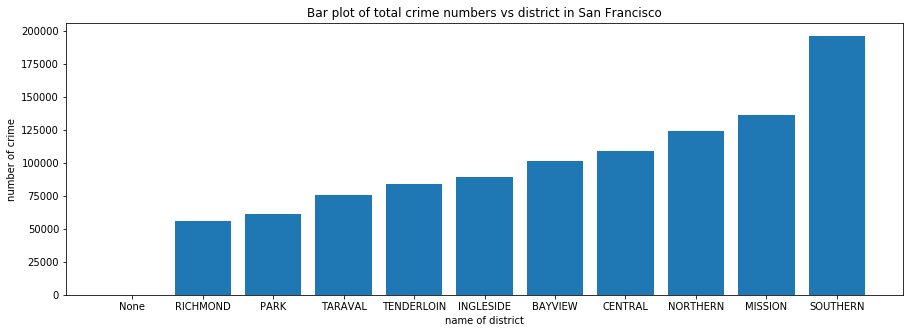

In [18]:
# draw a bar plot to show where has the most crime
y = np.array(crime_freq.loc[:, 'count'])
x = np.array(range(len(crime_freq)))
name = np.array(crime_freq.loc[:, 'PdDistrict'])
plt.figure(figsize=(15,5))
plt.xticks(x, name)
plt.xlabel('name of district')
plt.ylabel('number of crime')
plt.title('Bar plot of total crime numbers vs district in San Francisco')
plt.bar(x,y)

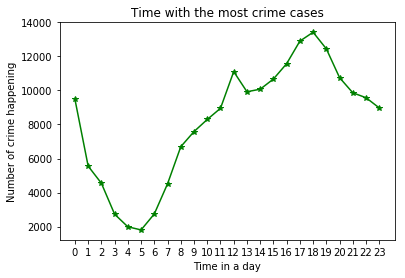

In [20]:
import datetime,time
crime_time = pd.read_sql("SELECT Datetime FROM crime WHERE PdDistrict = 'SOUTHERN' ",db)
#covert time string to datetime type
crime_time['Datetime'] = pd.to_datetime(crime_time['Datetime'], format = '%Y-%m-%d %H:%M:%S')
crime_time = crime_time['Datetime']
#calculate at which hour the most cases occur
crime_time = Counter([x.hour for x in crime_time])
crime_time = pd.DataFrame(list(crime_time.items()), columns = ['time','count'])
crime_time = crime_time.sort_values(by = ['time'])
# draw line chat to show when the most crime cases occur
a=np.array(crime_time.iloc[:,0])
b=np.array(crime_time.iloc[:,1])
plt.plot(a,b,marker = '*', c = 'green')
plt.xticks(a,a)
plt.xlabel('Time in a day')
plt.ylabel('Number of crime happening')
plt.title('Time with the most crime cases')
plt.show()#the most crime occur at 6 pm

(37.7, 37.82)

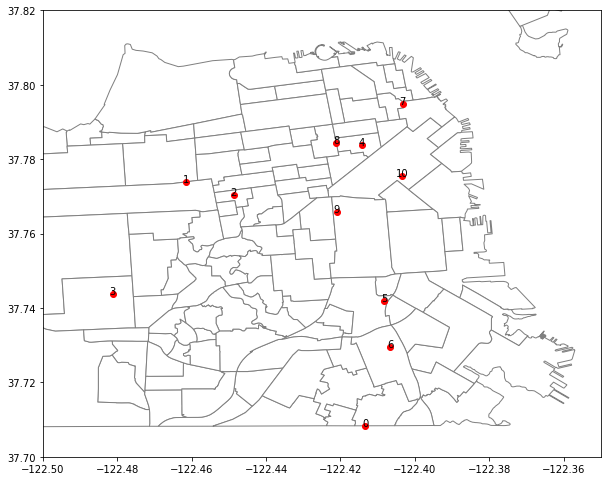

In [178]:
# label the ten district in map and the district with larger number are more dangerous
lnglat = [geom.Point(x) for x in zip(crime_freq.Lon, crime_freq.Lat)]
crime_freq = gpd.GeoDataFrame(crime_freq, geometry = lnglat)
ax = neighborhood.plot(edgecolor = "gray", color = "white", figsize = (10, 10))
crime_freq.plot(ax = ax, marker = 'o',c = 'red')
crime_freq.apply(add_label, axis = 1)
plt.xlim(-122.5, -122.35)
plt.ylim(37.7,37.82)

From the bar plot and the map we can know that SOUTHERN district is the most dangerous place and MISSON BAY follows. It can be partially explained by the geographic location. As these two district is near sea, there are more people live, work and here. With larger volume of people, more criminals tend to come here and commit crimes because here exist large amounts of potential targets for crime. Similarity, it is easy to explain why the most crime occur at 6 pm. Since at 6 pm, most people finish their daily work and start to relax themselves by eating outside or shopping or just hanging out. Then more people stay outside and it is also a good time for criminals to commit crimes like robbery or theft. Moreover, in crowd, some extremist may try to do something to cause social panic like explosion, shooting or hit innocent people by cars. Therefore, more crimes occur in evening peak period.

3.Are noise complaints and mobile food vendors related?

In [23]:
noise = pd.read_sql("SELECT Lat, Lon FROM noise WHERE Lat >0", db)
noise.head()#select the geographic coordinates of noise reports

,Lat,Lon
0,37.769148,-122.424475
1,37.762047,-122.508365
2,37.787983,-122.414943
3,37.761385,-122.502232
4,37.742435,-122.420087


In [33]:
#Errors caused by re-run this cell and creating a same table in the same sql files
db.execute("CREATE TABLE loc_machine_count AS SELECT locationid, COUNT(*) AS count FROM mobile_food_schedule GROUP BY locationid")

OperationalError: table loc_machine_count already exists

In [24]:
pd.read_sql("SELECT * FROM loc_machine_count", db).head()

,locationid,count
0,305727,14
1,305735,14
2,321365,5
3,334914,11
4,338539,3


In [25]:
#merge the machine's location id with there geographic coordinates
location_machine = pd.read_sql('''
SELECT L.*, R.locationid, R.Latitude, R.Longitude
FROM loc_machine_count AS L INNER JOIN mobile_food_locations AS R ON L.locationid = R.locationid
''',db)
location_machine = location_machine[location_machine['Longitude'] != 0].iloc[:,1:5]
location_machine.head()

,count,locationid,Latitude,Longitude
1,14,305735,37.786206,-122.402532
2,5,321365,37.787042,-122.400427
3,11,334914,37.783470,-122.408041
4,3,338539,37.795701,-122.398490
5,3,338548,37.797455,-122.399011


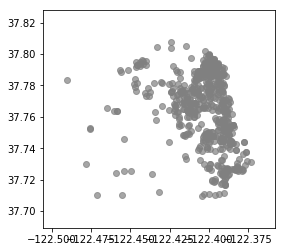

In [161]:
#plot the location of all food machine
lnglat = [geom.Point(x) for x in zip(location_machine.Longitude, location_machine.Latitude)]
location_machine = gpd.GeoDataFrame(location_machine, geometry = lnglat)
location_machine.plot(color="gray",alpha=0.7)

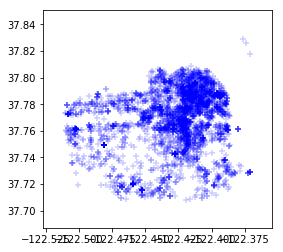

In [27]:
#plot the location of all noise reports
lnglat1 = [geom.Point(x) for x in zip(noise.Lon, noise.Lat)]
noise = gpd.GeoDataFrame(noise, geometry = lnglat1)
noise.plot(color="blue",marker = '+', alpha=0.2)

/anaconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


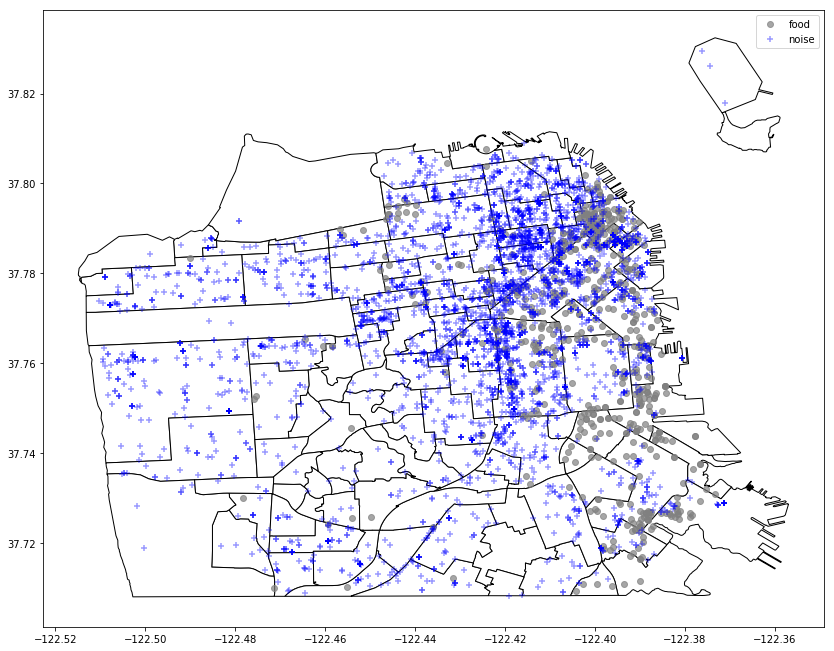

In [162]:
#draw noise location and food machine location at the same map
ax = neighborhood.plot(edgecolor = "black", color = "white", figsize = (14, 14))
low = location_machine.plot(ax = ax, color="gray", alpha=0.7)
up = noise.plot(ax = ax, color="blue",marker = '+', alpha=0.4)
plt.legend([low, up], labels = ['food', 'noise'], loc = 'best')

In the map above, blue points represent the noise places and the grey plots represent the food machine places. From the distribution of dots we can find that more food vendors locate in northwestern San Francisco and some food vendors located in southwestern part. But little of food vendors located in eastern part of San Francisco. As for noisy place, more noise are reported in northwestern, which is overlapped with the gathering place of food vendors. Howerver, other nosie appears randomly in the rest part of San Francisco, which is obviously different to the distribution of food mathines. Thus we cannot make the conclution that noise complaints are related with mobile food vendors. There may exist som confounding variables between noise complaints and mobile food vendors such as the volume of population and the living conditions in each district. It is possible that the noise was both cause by living condition and the flow of people, but the locations of food vendors are determined by the volume of people. In this assumption, it is easier to explain why the locations of food vendors and the loctions of noise are both converged in northeastern part but the rest locations are totally differentely distributed.

4.What are the best times and places to find food trucks

In [30]:
permit = pd.read_sql("SELECT permit FROM mobile_food_permits WHERE Status = 'APPROVED' AND FacilityType = 'Truck'", db)
permit_num = []
for x in list(range(len(permit))):
    permit_num.append(permit.iloc[x,0])
permit_num#obtain the permits and return a list

['16MFF-0027',
 '16MFF-0069',
 '16MFF-0051',
 '16MFF-0024',
 '16MFF-0036',
 '16MFF-0037',
 '16MFF-0047',
 '16MFF-0053',
 '16MFF-0071',
 '16MFF-0046',
 '16MFF-0023',
 '16MFF-0019',
 '16MFF-0055',
 '16MFF-0034',
 '15MFF-0023',
 '16MFF-0032',
 '16MFF-0038',
 '16MFF-0033',
 '16MFF-0117',
 '16MFF-0076',
 '16MFF-0079',
 '16MFF-0080',
 '12MFF-0106',
 '16MFF-0087',
 '16MFF-0068',
 '16MFF-0095',
 '16MFF-0096',
 '16MFF-0114',
 '16MFF-0118',
 '16MFF-0119',
 '15MFF-0136',
 '15MFF-0009',
 '15MFF-0151',
 '16MFF-0142',
 '16MFF-0124',
 '15MFF-0143',
 '16MFF-0044',
 '16MFF-0121',
 '16MFF-0007',
 '15MFF-0156',
 '16MFF-0008',
 '17MFF-0009',
 '15MFF-0132',
 '17MFF-0080',
 '17MFF-0125',
 '17MFF-0126']

In [31]:
place = pd.read_sql("SELECT locationid, permit, EndHour, StartHour FROM mobile_food_schedule", db)
place = place[place['permit'].isin(permit_num)]
place.head()#obtian the working time of approved mobile food vendor

,locationid,permit,EndHour,StartHour
822,654163,15MFF-0009,14,10
823,654163,15MFF-0009,14,10
824,654163,15MFF-0009,14,10
825,654165,15MFF-0009,14,10
826,654165,15MFF-0009,14,10


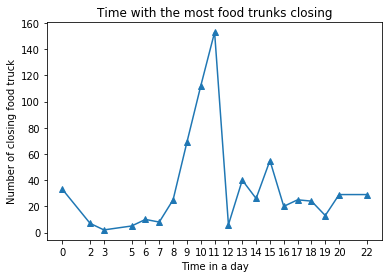

In [32]:
#find the time when most vendors close
end = Counter(list(place.iloc[:, 2]))
end = pd.DataFrame(list(end.items()), columns = ['time','count'])
end = end.sort_values(by = ['time'])
a=np.array(end.iloc[:,0])
b=np.array(end.iloc[:,1])
plt.plot(a,b,marker = '^')
plt.xticks(a,a)
plt.xlabel('Time in a day')
plt.ylabel('Number of closing food trucks')
plt.title('Time with the most food trucks closing')
plt.show()

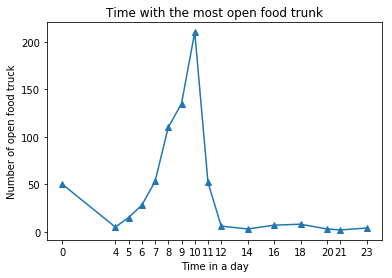

In [33]:
#find the time when most vendors open
start = Counter(list(place.iloc[:, 3]))
start = pd.DataFrame(list(start.items()), columns = ['time','count'])
start = start.sort_values(by = ['time'])
a=np.array(start.iloc[:,0])
b=np.array(start.iloc[:,1])
plt.plot(a,b,marker = '^')
plt.xticks(a,a)
plt.xlabel('Time in a day')
plt.ylabel('Number of open food truck')
plt.title('Time with the most open food trunk')
plt.show()

In [34]:
loc = Counter(list(place.iloc[:, 0]))
loc.most_common(5)

[(765691, 15), (765710, 15), (762178, 10), (762186, 10), (762187, 10)]

In [54]:
a = location_machine[location_machine['locationid'] == 765710]
a

,count,locationid,Latitude,Longitude,geometry
267,15,765710,37.744178,-122.386716,POINT (-122.386715929759 37.7441784473757)


In [55]:
b = location_machine[location_machine['locationid'] == 765691]
b

,count,locationid,Latitude,Longitude,geometry
248,15,765691,37.744752,-122.385679,POINT (-122.385679248721 37.7447521916164)


/anaconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/legend.py:1357: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


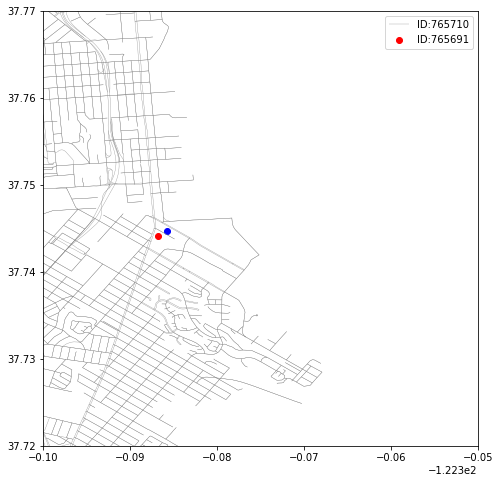

In [61]:
#draw the location of most vendors locating
sf_area = ox.graph_from_place("San Francisco",network_type='drive')
nodes, edges = ox.graph_to_gdfs(sf_area)
ax = edges.plot(color = "gray", linewidth = 0.3, figsize = (8, 8))
a1 = a.plot(ax = ax, color = 'red')
b1 = b.plot(ax = ax, color = 'blue')
ax.set_xlim([-122.40, -122.35])
ax.set_ylim([37.72, 37.77])
plt.legend([a1, b1], labels = ['ID:765710', 'ID:765691'], loc = 'best')

From the first line chart we know that most vendor open at 10 am and close at 11 pm. Then during 10 to 11, there must have the most mobile food vendor open. That is, time period from 10 am to 11 am is the best time to find food trucks. This may caused by the fact that some food trucks aim to sale breakfast so they open early and close before noon. And some food truck generally sale lunch meals and usually they will open at 10 am and close after lunch or even after evening time. Since the space of food truck is limited, it is impossible for merchant store too much materials in cars and provide meals for whole day. The location with most trunks can also be explained by the large volume of people. Because of the large flow of population in this area, marketing here is large and prospective and merchants are willing to sale food here with earning more money. That is why in these two location have the most mobile food trucks.

5.Is there a relationship between housing prices and any of the other tables?

In [123]:
schools = pd.read_sql("SELECT * FROM schools", db)
schools.head()

,Name,Entity,LowerGrade,UpperGrade,GradeRange,Category,LowerAge,UpperAge,GeneralType,Address,Lat,Lon
0,Alamo Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"250 23RD AVE, San Francisco, CA 94121",37.783005,-122.482300
1,Alvarado Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"625 DOUGLASS ST, San Francisco, CA 94114",37.753681,-122.438194
2,Aptos Middle School,SFUSD,6,8,6-8,USD Grades 6-8,11,13,PS,"105 APTOS AVE, San Francisco, CA 94127",37.729672,-122.465782
3,Argonne Early Education School,SFUSD,-2,0,PK-TK,USD PreK/TK,3,5,PS,"750 16TH AVE, San Francisco, CA 94118",37.773968,-122.474060
4,Argonne Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"680 18TH AVE, San Francisco, CA 94121",37.775307,-122.476311


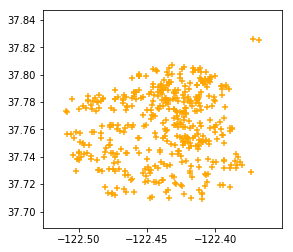

In [136]:
lnglat2 = [geom.Point(x) for x in zip(schools.Lon, schools.Lat)]
schools = gpd.GeoDataFrame(schools, geometry = lnglat2)
schools.plot(color="orange",marker = '+')

In [100]:
median_price.index

Int64Index([94080, 94102, 94103, 94105, 94107, 94109, 94110, 94112, 94114,
            94115, 94116, 94117, 94118, 94121, 94122, 94123, 94124, 94127,
            94131, 94132, 94133, 94134, 94158],
           dtype='int64', name='RegionName')

In [163]:
median_price1 = median_price.copy()
median_price1.loc[:, 'RegionName'] = median_price1.index
median_price1 = median_price1.reset_index(drop = True)
median_price1.head()

,MedianSoldPricePerSqft_AllHomes,RegionName
0,440.870467,94080
1,771.767609,94102
2,772.299804,94103
3,1001.785313,94105
4,813.582972,94107


In [164]:
sf_zip = zipcode.iloc[:, [0,5]]
price2 = pd.merge(sf_zip, median_price1, how = 'inner', left_on = 'ZCTA5CE10', right_on = 'RegionName')
price2.head()

,ZCTA5CE10,geometry,MedianSoldPricePerSqft_AllHomes,RegionName
0,94102,"POLYGON ((-122.429929 37.777909, -122.426829 3...",771.767609,94102
1,94116,"POLYGON ((-122.510297 37.764073, -122.509833 3...",615.363240,94116
2,94158,"POLYGON ((-122.397866 37.772323, -122.396381 3...",1120.358515,94158
3,94117,"POLYGON ((-122.477297 37.766069, -122.473124 3...",809.329609,94117
4,94110,"POLYGON ((-122.426722 37.736372, -122.425082 3...",791.161609,94110


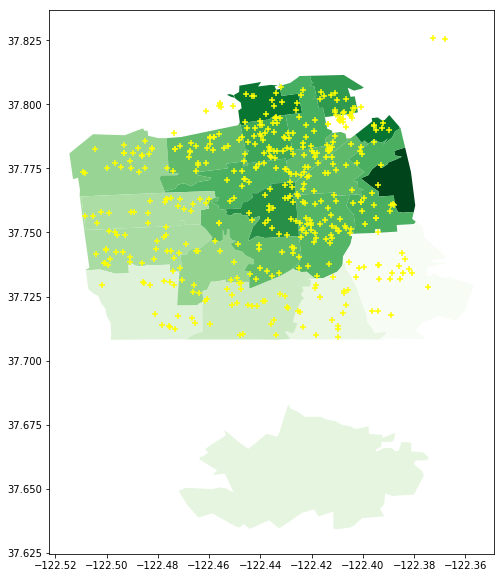

In [184]:
#draw school location plot on the San Francisco map
#draw map with different color acccoding to house price
base = price2.plot(cmap=plt.cm.Greens, column='MedianSoldPricePerSqft_AllHomes', figsize = (10,10))
schools.plot(ax = base, color="yellow",marker = '+')

In [165]:
parking = pd.read_sql("SELECT * FROM parking", db)
parking.head()

,Owner,Address,PrimeType,SecondType,GarOrLot,RegCap,ValetCap,MCCap,LandType,Lat,Lon
0,Private,2110 Market St,PPA,,L,13,0,0,restaurant,37.767378,-122.429344
1,SFMTA,993 Potrero,PPA,,L,34,0,0,,37.757272,-122.406320
2,Port of SF,601 Terry A Francois Blvd,PPA,,L,72,0,0,,37.770135,-122.385801
3,Private,11 SOUTH VAN NESS,PHO,CPO,G,130,0,0,,37.774150,-122.418402
4,Private,101 CALIFORNIA ST,PPA,,G,250,0,0,,37.793243,-122.397495


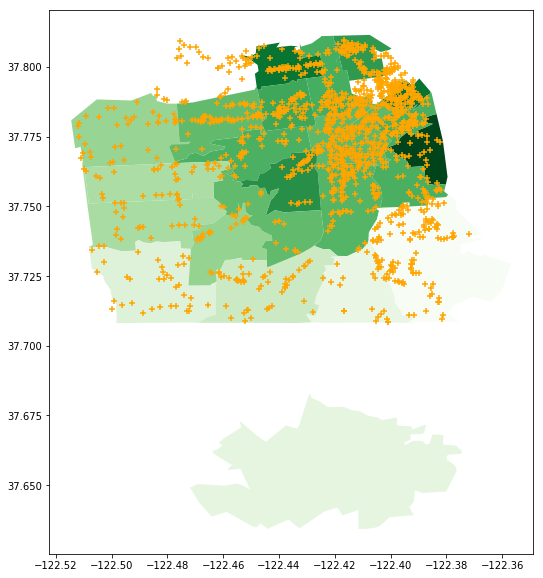

In [179]:
#draw parking postion plot on the San Francisco map
#draw map with different color acccoding to house price
lnglat3 = [geom.Point(x) for x in zip(parking.Lon, parking.Lat)]
parking = gpd.GeoDataFrame(parking, geometry = lnglat3)
base = price2.plot(cmap=plt.cm.Greens, column='MedianSoldPricePerSqft_AllHomes', figsize = (10,10))
parking.plot(ax = base, color="orange",marker = '+')

As for the base map of San Francisco, different districts are filled with different color. District with higher median house sold price is filled with darder green and the district with lower median house sold price has lighter green filled in. Then draw school postions (the yellow points on map) and parking postions (the orange points on map) on colored San Francisco map repectively. We can find that on school map, the location of schools are almost randomly distributed, but the parking postions are converged in northeastern part of San Francisco. Coincidentally, the house sold price in this part is also relatively higher than other part. Then from the plot 2 (the parking position plot) we may infer that there exist some relationship between parking postions and house sold price. The relationship may be also caused by the population volume. Since more people need more parking lot and more people may caused higher house price (explained in part 1).